Half-angle α: 1.12497 rad, 64.46°, 0.358π
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
Completed 1 out of 501 rows.
C

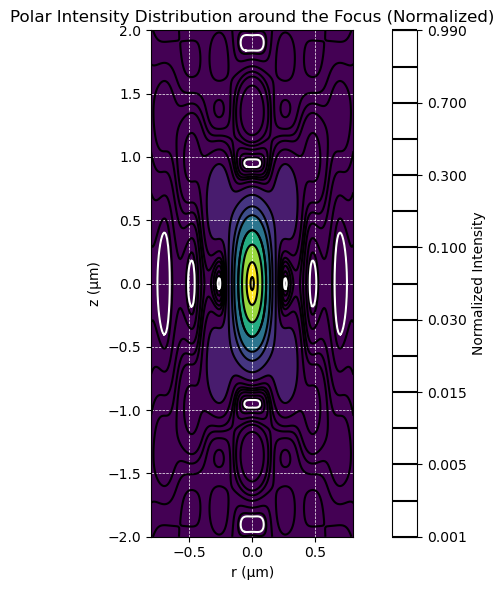

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  1 15:57:11 2025

@author: ernststelzer
"""

#!/usr/bin/env python3
# -----------------------------------------------------------------------------
# Author:           Ernst HK Stelzer
# Date & Time:      2025-04-01 12:00:00 (Code generation time)
# OpenAI Model:     ChatGPT based on GPT-4 (precise version: GPT-4)
#
# Description:
#   This script computes the polar point spread function (PSF) of a cylindrically
#   symmetric lens and produces a contour plot of the polar intensity distribution
#   around the focus. The PSF is calculated via numerical integration of a complex
#   function (with real and imaginary parts integrated separately) based on a
#   formulation derived from a Wolfram Mathematica expression.
#
# Physical and Derived Parameters:
#   - Numerical Aperture (NA):          1.2
#   - Refractive Index (n):              1.33
#   - Wavelength (λ):                    514 nm  (i.e., 0.514 µm)
#   - Half-angle (α):
#         α = arcsin(NA/n)  ≈ 1.13000 rad 
#         ≈ 64.74°  ≈ 0.359 π  (fraction of π)
#
# Grid Ranges and Matrix Size:
#   - Axial coordinate z: from -2.0 µm to 2.0 µm with exactly 501 values
#   - Radial coordinate r:  from -0.8 µm to 0.8 µm with exactly 201 values
#   - Final PSF matrix: 501 (z) x 201 (r) complex numbers
#
# Contour Plot Specifications:
#   - Intensity Normalization: The intensities are normalized so that the center
#         (r = 0, z = 0) intensity equals 1.0.
#   - Contour levels (Born & Wolf): 
#         0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05,
#         0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 0.99
#   - Intensity mapping: 
#         Linear grayscale mapping increasing from 0.0 (black) to 1.0 (white);
#         Intensities below 0.001 are rendered as black;
#         Intensities above 0.99 are rendered as white.
#   - Grid lines: Thin white grid lines are overlaid.
#   - Special contour line colors:
#         * The 0.001 contour line is displayed in white.
#         * The 0.5 contour line is displayed in black.
#   - Aspect Ratio: Equal scaling on both axes (aspect ratio = 1).
#
# Output Files:
#   - Real part of PSF:
#         "bwPSF_Real_n133_wl514_NA12_r08_z20.csv"
#   - Imaginary part of PSF:
#         "bwPSF_Imaginary_n133_wl514_NA12_r08_z20.csv"
#   - Normalized positive intensity coordinates:
#         "bwPSF_IntensitiesCoordinates_n133_wl514_NA12_r08_z20.csv"
#     Format: Each row contains {r [µm], z [µm], intensity (rounded to 5 digits)}
#
# Important Note on Numerical Integration:
#   The integral in the Mathematica expression is complex-valued. Here, the
#   integration is performed separately for the real and imaginary parts using:
#
#       real_integral, _ = quad(lambda rho: np.real(integrand(rho, v, u)),
#                                0, 1, epsabs=precision, limit=100)
#       imag_integral, _ = quad(lambda rho: np.imag(integrand(rho, v, u)),
#                                0, 1, epsabs=precision, limit=100)
#       integral = real_integral + 1j * imag_integral
#
#   The resulting integral is then multiplied by the complex prefactor:
#
#       -(2π i n sin(α)^2/λ) * exp(i u/sin(α)^2)
#
# Note on Contour Plot Customization:
#   When generating the contour plot, the deprecated cs.collections attribute (deprecated
#   in Matplotlib 3.8 and removed in 3.10) is avoided. Instead, the code iterates over
#   cs.allsegs to set the contour line colors for levels 0.001 (white) and 0.5 (black),
#   ensuring compatibility with newer Matplotlib versions.
# -----------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import j0  # Bessel function of the first kind, order 0
import csv


# --------------------- Parameter Definitions -------------------------------
# Optical parameters
NA = 1.2
n = 1.33
wavelength_nm = 514.0            # in nanometers
wavelength_um = wavelength_nm * 1e-3  # convert nm to µm (0.514 µm)

# Calculate half-angle α in radians, degrees, and as fraction of π
alpha = np.arcsin(NA / n)          # in radians
alpha_deg = np.degrees(alpha)      # in degrees
alpha_frac = alpha / np.pi         # as fraction of π

print(f"Half-angle α: {alpha:.5f} rad, {alpha_deg:.2f}°, {alpha_frac:.3f}π")

# Integration precision (better than 1/1000)
precision = 1e-4

# Define grid ranges (in µm)
z = np.linspace(-2.0, 2.0, 501)    # axial coordinate z: 501 points from -2.0 µm to 2.0 µm
r = np.linspace(-0.8, 0.8, 201)     # radial coordinate r: 201 points from -0.8 µm to 0.8 µm

# Create meshgrid for z and r; the PSF matrix will be indexed as [z_index, r_index]
Z, R = np.meshgrid(z, r, indexing='ij')  # Shape: (501, 201)

# --------------------- Define the PSF Calculation ---------------------------
# The integrand corresponds to:
#    j0(v * ρ) * exp(-1/2 i * u * ρ^2) * ρ
# with the substitutions:
#    v = (2π n r sin(α))/λ   and   u = (2π n z sin(α)^2)/λ.
def integrand(rho, v, u):
    return j0(v * rho) * np.exp(-0.5j * u * (rho**2)) * rho

# Initialize the PSF complex array (501 x 201)
PSF = np.zeros((len(z), len(r)), dtype=complex)

# Loop over each (z, r) grid point to compute the PSF
# Note: This double loop may be computationally intensive.
for i, z_val in enumerate(z):
    # Compute the axial parameter u for the given z value
    u_val = 2 * np.pi * n * z_val * (np.sin(alpha)**2) / wavelength_um
    for j, r_val in enumerate(r):
        # Compute the radial parameter v for the given r value
        v_val = 2 * np.pi * n * r_val * np.sin(alpha) / wavelength_um
        # Compute the complex prefactor:
        #   -(2π i n sin(α)^2/λ) * exp(i u / sin(α)^2)
        prefactor = -(2 * np.pi * 1j * n * (np.sin(alpha)**2) / wavelength_um) * \
                    np.exp(1j * u_val / (np.sin(alpha)**2))
        # Perform the numerical integration separately for real and imaginary parts
        integral, _ = quad(lambda rho: integrand(rho, v_val, u_val),
                     0, 1, epsabs=precision, limit=100, complex_func=True)
        # Compute the PSF value at this grid point
        PSF[i, j] = prefactor * integral
        if i % 50 == 0:
            print(f"Completed {i+1} out of {len(z)} rows.")

    # Compute the intensity distribution using the complete conjugate of the PSF
    intensity = np.abs(PSF * np.conj(PSF))


# Normalize the intensity so that the center (r = 0, z = 0) equals 1.0.
# Find the indices closest to zero for z and r.
idx_z = np.argmin(np.abs(z))
idx_r = np.argmin(np.abs(r))
center_intensity = intensity[idx_z, idx_r]
intensity_norm = intensity / center_intensity

print(f"Center intensity (before normalization): {center_intensity:.5e}")
print("Intensity has been normalized so that the center equals 1.0.")

# --------------------- Save Output CSV Files -------------------------------
# Save the real part of the PSF matri/Users/ernststelzer/.spyder-py3/untitled1.pyx
np.savetxt("/Users/ernststelzer/.spyder-py3/bwPSF_Real_n133_wl514_NA12_r08_z20.csv", PSF.real, delimiter=",")
# Save the imaginary part of the PSF matrix
np.savetxt("/Users/ernststelzer/.spyder-py3/bwPSF_Imaginary_n133_wl514_NA12_r08_z20.csv", PSF.imag, delimiter=",")

# Save the coordinates and normalized positive intensity values as triples {r, z, intensity}
with open("/Users/ernststelzer/.spyder-py3/bwPSF_IntensitiesCoordinates_n133_wl514_NA12_r08_z20.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["r (µm)", "z (µm)", "intensity"])
    for i, z_val in enumerate(z):
        for j, r_val in enumerate(r):
            writer.writerow([f"{r_val:.5f}", f"{z_val:.5f}", f"{intensity_norm[i, j]:.5f}"])

# --------------------- Generate the Contour Plot -----------------------------
# Define the contour levels (Born & Wolf)
contour_levels = [0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05,
                  0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 0.99]

plt.figure(figsize=(8, 6))
# Use a discrete colormap so every area between contour levels gets a unique color.
# Create a colormap with len(contour_levels)-1 distinct colors.
cmap = plt.get_cmap('viridis', len(contour_levels) - 1)
cf = plt.contourf(r, z, intensity_norm, levels=contour_levels,
                  cmap=cmap, extend='both')
# Generate contour lines (default black) for all levels
cs = plt.contour(r, z, intensity_norm, levels=contour_levels, colors='k')

# Instead of using the deprecated cs.collections attribute, iterate over cs.allsegs
# to set specific contour line colors for levels 0.001 (white) and 0.5 (black)
for idx, segs in enumerate(cs.allsegs):
    level = contour_levels[idx]
    if np.isclose(level, 0.001):
        for seg in segs:
            plt.plot(seg[:, 0], seg[:, 1], color='white', linewidth=1.5)
    elif np.isclose(level, 0.5):
        for seg in segs:
            plt.plot(seg[:, 0], seg[:, 1], color='black', linewidth=1.5)

# Overlay thin white grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5)

plt.xlabel("r (µm)")
plt.ylabel("z (µm)")
plt.title("Polar Intensity Distribution around the Focus (Normalized)")
plt.colorbar(label="Normalized Intensity")
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# Description:
   This script computes the polar point spread function (PSF) of a cylindrically
   symmetric lens and produces a contour plot of the polar intensity distribution
   around the focus. The PSF is calculated via numerical integration of a complex
   function (with real and imaginary parts integrated separately) based on a
   formulation derived from a Wolfram Mathematica expression.